In [5]:
import torch
import torch.nn as nn

class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


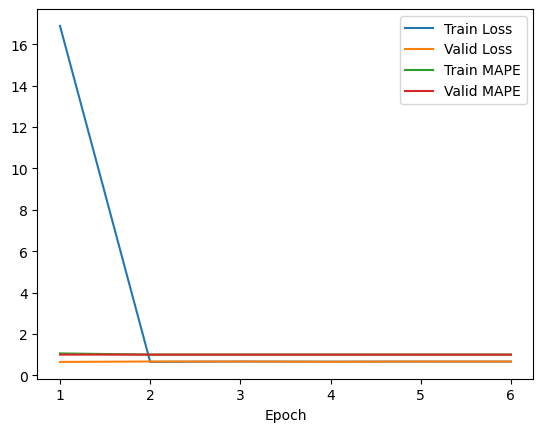

Early stopping at epoch 6


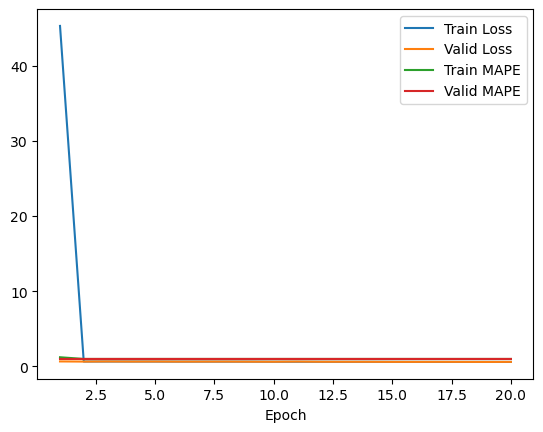

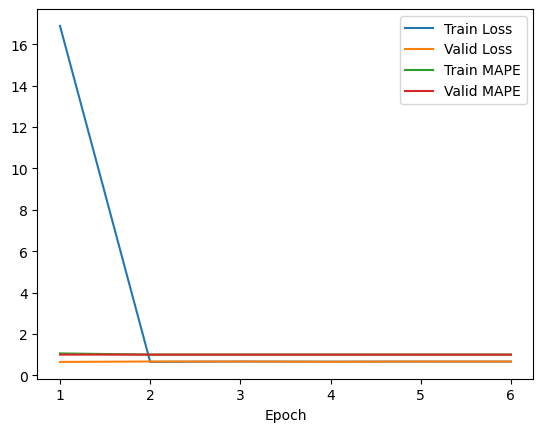

In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
import numpy as np

# 1) 하이퍼파라미터
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2) 데이터 준비 (NumPy 로드 → Dataset → DataLoader)
data = np.load('dataset/traffic_dataset_13.npy')  # (T_total, E, C_all)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)
split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# 3) Baseline 모델 정의
class MLPBaseline(nn.Module):
    def __init__(self, T, E, D_in, n_pred, D_out, hidden_dim=256):
        super().__init__()
        self.n_pred, self.E, self.D_out = n_pred, E, D_out
        self.network = nn.Sequential(
            nn.Flatten(),  # B x (T*E*D_in)
            nn.Linear(T * E * D_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_pred * E * D_out)
        )

    def forward(self, x, edge_index=None, edge_attr=None):
        # x: [B, T, E, D_in]
        B = x.size(0)
        out = self.network(x)
        out = out.view(B, self.n_pred, self.E, self.D_out)
        return out

class CNN2DBaseline(nn.Module):
    def __init__(self, T, E, D_in, n_pred, D_out, hidden_dim=128):
        super().__init__()
        self.n_pred, self.E, self.D_out = n_pred, E, D_out
        self.conv = nn.Sequential(
            nn.Conv2d(D_in, hidden_dim, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_pred * E * D_out)
        )

    def forward(self, x, edge_index=None, edge_attr=None):
        # x: [B, T, E, D_in] -> [B, D_in, T, E]
        x = x.permute(0, 3, 1, 2)
        h = self.conv(x)
        h = self.pool(h)
        B = x.size(0)
        out = self.fc(h)
        out = out.view(B, self.n_pred, self.E, self.D_out)
        return out

# 4) 손실 함수 & 옵티마이저 설정
# - MSELoss: 평균제곱오차, L1Loss: 평균절대오차 중 선택 가능
criterion = MAPELoss
optimizer_fn = lambda model: AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# 5) 모델 학습 및 평가
for ModelClass, name in [(MLPBaseline, "MLP Baseline"), (CNN2DBaseline, "2D CNN Baseline")]:
    print(f"\n=== Training {name} ===")
    # 모델 인스턴스
    sample_batch, _ = next(iter(train_loader))
    _, T, E, D_in = sample_batch.shape
    _, _, _, D_out = sample_batch[..., :3].shape  # y의 채널 수
    model = ModelClass(T, E, D_in, N_PRED, D_out)
    
    # Trainer 초기화
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer_fn(model),
        criterion=criterion,
        epochs=EPOCHS,
        device=DEVICE
    )
    # 학습 실행
    trainer.fit()
    # 기록 저장 (옵션)
    # history = trainer.get_history()
    # torch.save(model.state_dict(), f"{name.replace(' ', '_').lower()}_best.pt")


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
from torch.optim import AdamW

# 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
WINDOW = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS = [0, 1, 2]

# 데이터 로드
T_total, E, _ = data.shape

# 모델 로드 (MLPBaseline 예시)
class MLPBaseline(torch.nn.Module):
    def __init__(self, T, E, D_in, n_pred, D_out, hidden_dim=256):
        super().__init__()
        self.n_pred, self.E, self.D_out = n_pred, E, D_out
        self.network = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(T * E * D_in, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, n_pred * E * D_out)
        )

    def forward(self, x, edge_index=None, edge_attr=None):
        B = x.size(0)
        out = self.network(x)
        return out.view(B, self.n_pred, self.E, self.D_out)

# 인스턴스화 및 가중치 로드
# 경로는 실제 저장된 파일 이름에 맞춰 조정하세요.
model = MLPBaseline(WINDOW, E, 5, len(PRED_OFFSETS), 3).to(DEVICE)
model.load_state_dict(torch.load('mlp_baseline_best.pt', map_location=DEVICE))
model.eval()

# 예측 연속 시계열 복구용 배열 초기화
pred_series = {edge: np.full(T_total, np.nan, dtype=np.float32) for edge in EDGE_IDS}
actual_series = data[:, EDGE_IDS, 0]  # 채널 0 실제값

# 슬라이딩 윈도우 예측
with torch.no_grad():
    for t0 in range(WINDOW - 1, min(960, T_total - max(PRED_OFFSETS))):
        # 입력 윈도우 슬라이스
        x_window = data[t0 - WINDOW + 1:t0 + 1, :, :3]  # [T, E, 3]
        x_batch = torch.from_numpy(x_window[None]).float().to(DEVICE)  # [1, T, E, 3]
        pred = model(x_batch)  # [1, n_pred, E, D_out]
        pred = pred.cpu().numpy()[0]  # [n_pred, E, D_out]

        # 각 offset에 맞춰 복구
        for i, offset in enumerate(PRED_OFFSETS):
            t_pred = t0 + offset
            for edge in EDGE_IDS:
                pred_series[edge][t_pred] = pred[i, edge, 0]  # D_out=3 중 채널 0 사용

# 플롯
plt.figure(figsize=(12, 6))
t_range = np.arange(0, 960)
for edge in EDGE_IDS:
    plt.plot(t_range, actual_series[:960, EDGE_IDS.index(edge)], label=f'Actual Edge {edge}')
    plt.plot(t_range, pred_series[edge][:960], '--', label=f'Predicted Edge {edge}')
plt.xlabel('Time Step')
plt.ylabel('Value (Channel 0)')
plt.title('Actual vs. Reconstructed Continuous Predictions (Edges 0,1,2)')
plt.legend()
plt.show()


RuntimeError: Given groups=1, weight of size [128, 5, 3, 3], expected input[1, 3, 12, 50] to have 5 channels, but got 3 channels instead